# **Geological facies connectivity and upscaling in reservoir simulation for production forecasts optimization**
## __3D Results__


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import StrMethodFormatter

import scipy

import os

conDir = ['./3d/3dcon/', './3d/3dint/', './3d/3ddis/']
varDir = ['0.5/', '1/', '2/']
stCon = ['HCS', 'ICS', 'LCS']

nseeds = 128
lc = 16
con = [2, 1, 3]
varSim = [0.5, 1, 2] 
scales = np.array([1,2,4,8,16,32,64,128,256]) 
scaleAtt = np.linspace(1,256,1000)

linestyle = ['dashed', 'dotted', 'dashdot']
marker = ['^', 'o', 's', '^']
color = ['red', 'darkgreen', 'navy']

scale_col = ["black","green","navy","purple","red"]

## __3D Fine grid values calculation__
<ul>
<li>Arithmetic mean</li>
<li>Geometric mean</li>
<li>Variance</li>
</ul>

In [ ]:
### 3D Fine grid values calculation ###

def calculate_statistics(base_path, varDir, nseeds):
    """Calculate statistics for fine grid values across different connectivity structures and variances."""
    
    k_arr = np.array([])
    kg_arr = np.array([])
    var_arr = np.array([])
    
    for ivar in range(len(varDir)):
        rdir = varDir[ivar]
        k1 = np.array([])
        kg1 = np.array([])
        var1 = np.array([])
        
        for iseed in range(nseeds):
            try:
                filepath = f"{base_path}{rdir}{iseed}/k.npy"
                aux = np.load(filepath).reshape(-1)
                
                k1 = np.append(k1, np.mean(aux))
                kg1 = np.append(kg1, np.exp(np.mean(np.log(aux))))
                var1 = np.append(var1, np.var(np.log(aux)))
            except Exception as e:
                print(f"Error processing {filepath}: {e}")
                continue
                
        k_arr = np.append(k_arr, np.mean(k1))
        kg_arr = np.append(kg_arr, np.mean(kg1))
        var_arr = np.append(var_arr, np.mean(var1))
        
    return (np.reshape(k_arr, (1,len(varDir))), 
            np.reshape(kg_arr, (1,len(varDir))), 
            np.reshape(var_arr, (1,len(varDir))))

# Calculate statistics for each connectivity type
connectivity_types = {
    'con': './3d/3dcon/',
    'int': './3d/3dint/',
    'dis': './3d/3ddis/'
}
results = {}

for conn_type, base_path in connectivity_types.items():
    k, kg, var = calculate_statistics(base_path, varDir, nseeds)
    results[conn_type] = {
        'k': k,
        'kg': kg,
        'var': var
    }
    print(f"\nResults for {conn_type}:")
    print(f"k: {k}, shape: {k.shape}")
    print(f"kg: {kg}, shape: {kg.shape}")
    print(f"var: {var}, shape: {var.shape}")

# Save results to .npz file
save_path = '3D_data/3D_fine_grid_stats.npz'
try:
    np.savez(save_path,
             k_con=results['con']['k'],
             kg_con=results['con']['kg'],
             var_con=results['con']['var'],
             k_int=results['int']['k'],
             kg_int=results['int']['kg'],
             var_int=results['int']['var'],
             k_dis=results['dis']['k'],
             kg_dis=results['dis']['kg'],
             var_dis=results['dis']['var'])
    print(f"\nData saved successfully to {save_path}")
except Exception as e:
    print(f"Error saving data: {e}")

In [2]:
kFG = np.array([[1.30545618, 1.6834693,  2.787084], [1.27600733, 1.62878823, 2.65592613], [1.2507993,  1.58485182, 2.56064046]])
kgFG = np.array([[1.02168354, 1.03083426, 1.04394775], [0.99990254, 0.99989306, 0.99991055], [0.97888048, 0.97029386, 0.95830883]])
varFG = np.array([[0.48987861, 0.97975722, 1.95951443], [0.48733629, 0.97467257, 1.94934514], [0.48987861, 0.97975722, 1.95951443]])

## __Analytical functions definition__
### From Eberhard et al., 2006.

#### a. Equivalent hydraulic conductivity as a function of coarsening scale
$$ \ \left \langle K_{eq} \right \rangle  \left ( \lambda \right ) = \left \langle Y \right \rangle exp\left \{ -\frac{\sigma _{Y}^{2}}{D}+\frac{\sigma _{Y}^{2}}{D} \left [erf\left ( \frac{Ia_{s}}{\sqrt{2}\lambda } \right )  \right ]^{D}  \right \} $$

#### b. Variance of log of equivalent hydraulic conductivity as a function of coarsening scale
$$ \ \sigma_{log\left ( K_{eq} \right )}^{2}  \left ( \lambda \right ) =  K_{g}^{2} + \sigma _{Y}^{2} \left [erf\left ( \frac{Ia_{s}}{\sqrt{2}\lambda } \right )  \right ]^{D}  $$

In [3]:
### Attinger functions ###
def attinger_amean(variance, scale, a, lc, Kg): 
    keff_scale = Kg * np.exp((variance/6)+(variance/3)*(erf((lc*a)/(np.sqrt(2)*scale)))**3)
    return keff_scale

def attinger_var(variance, scale, a, lc, Kg): #Attinger (Eq. 3.2.3, Boschan & Noetinger 2012)
    var_scale = Kg**2 * variance * (erf ((lc*a)/(np.sqrt(2)*scale)))**3
    return var_scale

## __3D Geometric mean as a function of &lambda;/I__

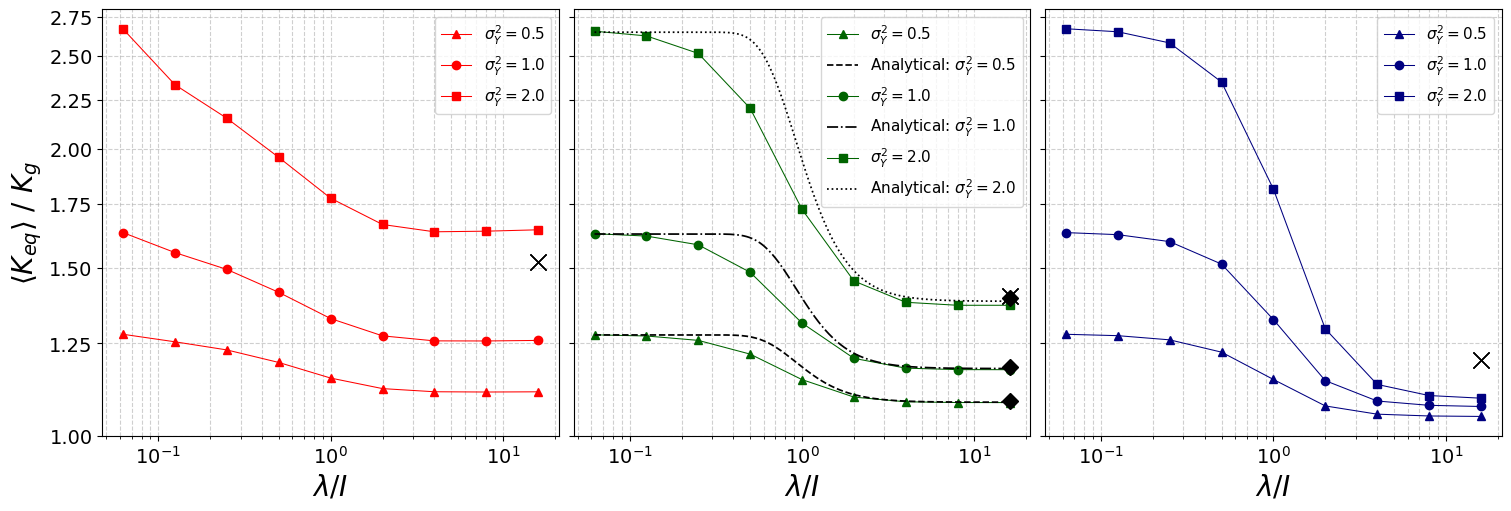

In [ ]:
### 3D Arithmetic mean - Plot from saved data ###

def load_and_plot_arithmetic_mean(data_file='3D_data/3D_arithmetic_mean_data.npz'):
    
    data = np.load(data_file, allow_pickle=True)
    results = data['results'].item()
    metadata = data['metadata'].item()
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5), layout='constrained', sharey=True)
    
    linestyle = ['--', '-.', ':']
    stCon = ['High Connectivity \nStructure', 'Intermediate Connectivity \nStructure', 'Low Connectivity \nStructure']
    
    for icon in range(len(conDir)):
        for ivar in range(len(varDir)):
            # Plot main data
            normalized_keff = results[icon][ivar]['normalized']
            ax[icon].loglog(scales/lc, normalized_keff,
                          color=color[icon], 
                          marker=marker[ivar],
                          markersize=6,
                          fillstyle='full',
                          linewidth=0.75,
                          linestyle='-',
                          label=rf'$\sigma^2_{{Y}}={varSim[ivar]:.1f}$')
            
            # Add analytical solution for intermediate connectivity
            if icon == 1:
                ax[1].loglog(scaleAtt/lc, 
                            attinger_amean(varFG[icon][ivar], scaleAtt, 1.3, lc, kgFG[icon][ivar]),
                            label=rf'Analytical: $\sigma^2_{{Y}}={varSim[ivar]:.1f}$',
                            color='black',
                            linewidth=1.25,
                            linestyle=linestyle[ivar])
            
            # Add reference points
            ax[icon].loglog(max(scales)/lc, metadata['reference_values']['janko'][icon],
                          marker='x', markersize=12,
                          color='black', fillstyle='full')
            if icon == 1:
                ax[1].loglog(max(scales)/lc, metadata['reference_values']['matheron'][ivar],
                            marker='D', markersize=8,
                            color='black', fillstyle='full')
                

        ax[icon].set_xlabel(r'$\lambda/I$', fontsize=20)
        if icon == 0:
            ax[icon].set_ylabel(r'$⟨K_{eq}⟩ \ / \ K_{g}$', fontsize=20)
        
        ax[icon].get_yaxis().set_major_formatter(ScalarFormatter())
        ax[icon].yaxis.set_minor_formatter(NullFormatter())
        ax[icon].set_yticks(ticks=np.arange(1,3,0.25), labels=np.arange(1,3,0.25))
        ax[icon].get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        ax[icon].tick_params(axis='both', labelsize=14)
        #ax[icon].set_title(stCon[icon], color=color[icon], fontsize=18, loc='left', weight='bold')
        ax[icon].legend(fontsize=11)
        ax[icon].grid(True, which='both', linestyle='--', alpha=0.3)

    #plt.suptitle("3D Arithmetic Mean", fontsize=20, weight='bold')
    
    # Save and show plot
    plt.savefig('3D_plots/3D_arithmetic_mean.png', dpi=100, bbox_inches='tight')
    plt.show()
    plt.close()

# Call the function to load and plot
load_and_plot_arithmetic_mean()

## __3D Arithmetic mean as a function of &lambda;/I__

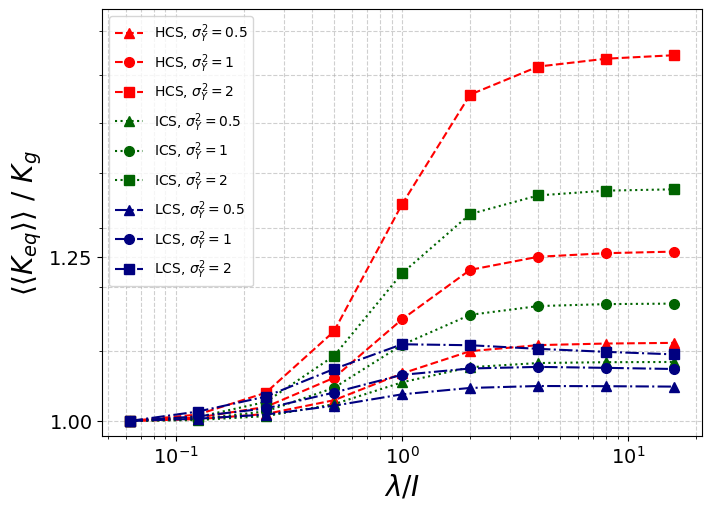

In [14]:
### 3D Geometric mean - Plot from saved data ###

def load_and_plot_geometric_mean(data_file='3D_data/3D_geometric_mean_data.npz'):
    """ Load and plot geometric mean data with consistent styling. """
    
    data = np.load(data_file, allow_pickle=True)
    results = data['results'].item()
    metadata = data['metadata'].item()

    fig, ax = plt.subplots(1, 1, layout="constrained", figsize=(7, 5))
    
    for icon in range(len(conDir)):
        for ivar in range(len(varDir)):
            normalized_keff = results[icon][ivar]['normalized']
            
            ax.loglog(scales/lc, normalized_keff,
                     label=f"{stCon[icon]}, $\\sigma^2_{{Y}}={varSim[ivar]}$",
                     color=color[icon],
                     marker=marker[ivar],
                     markersize=7,
                     fillstyle='full',
                     linewidth=1.5,
                     linestyle=linestyle[icon])
    
    ax.set_xlabel(r'$\lambda / I$', fontsize=20)
    ax.set_ylabel(r'$⟨⟨K_{eq}⟩⟩ \ / \ K_{g}$', fontsize=20)
    ax.get_yaxis().set_major_formatter(ScalarFormatter())
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.set_yticks(ticks=np.arange(0.75, 1.5, 0.25), labels=np.arange(0.75, 1.5, 0.25))
    ax.tick_params(axis='both', labelsize=14)
    ax.get_yaxis().set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    ax.set_ylim(0.98, 1.75)
    ax.legend(fontsize=10, frameon=True, loc='best')
    ax.grid(True, which='both', linestyle='--', alpha=0.6)
    
    plt.savefig('3D_plots/3D_geometric_mean.png', dpi=100, bbox_inches='tight')
    plt.show()

#os.makedirs('3D_plots', exist_ok=True)

load_and_plot_geometric_mean()

## __3D Probability density functions (PDF)__

In [ ]:
### Probability density function - Plot from saved data ###

def load_and_plot_detailed_pdfs(data_file='3D_data/3D_pdf_histogram_data.npz'):
    """ Load and plot detailed probability density functions from saved data. """
    
    # Setup colors and styles
    scale_col = [
        ["rosybrown", "lightcoral", "indianred", "red", "sienna", "darkred"],
        ["turquoise", "springgreen", "mediumseagreen", "lime", "green", "darkslategrey"],
        ["lightblue", "lightskyblue", "deepskyblue", "steelblue", "blue", "navy"]
    ]
    
    try:
        # Create output directory if it doesn't exist
        os.makedirs('3D_plots', exist_ok=True)
        
        # Load the saved data
        data = np.load(data_file, allow_pickle=True)
        variances = data['variances']
        connectivity = data['connectivity']
        scales = data['scales']
        hist_data = data['histogram_data']
        
        # Create plots for each variance value
        for ivar, variance in enumerate(variances):
            fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 6), layout='constrained')
            
            for icon, (ax, conn_type) in enumerate(zip(axes, connectivity)):
                hist_data_conn = hist_data[ivar][icon]
                
                for iscale, scale_data in enumerate(hist_data_conn):
                    if scale_data is not None:
                        ax.plot(scale_data['bin_centers'],
                               scale_data['counts'],
                               label=f'λ={scales[iscale]}',
                               color=scale_col[icon][iscale],
                               linewidth=2)
                
                # Customize each subplot
                ax.set_xlabel(r'$log(K_{eq})$', fontsize=20)
                if icon == 0:
                    ax.set_ylabel(r'$P[log(K_{eq})]$', fontsize=20)
                ax.tick_params(axis='both', labelsize=14)
                ax.legend(fontsize=12, frameon=True, loc='best')
                ax.set_title(f'{conn_type}', fontsize=16)
           
                # Add grid
                ax.grid(True, alpha=0.6)
            
            # Set overall title and save
            variance_str = variance.rstrip('/')  # Remove trailing slash
            plt.suptitle(f'PDF for variance {variance_str}', fontsize=18)
            
            # Fix the file path formatting
            save_path = os.path.join('3D_plots', f'3D_pdf_variance_{variance_str}.png')
            plt.savefig(save_path, dpi=100, bbox_inches='tight')
            plt.close()
            print(f"Saved plot to {save_path}")
            
    except Exception as e:
        print(f"Error loading or plotting data: {e}")
        raise 

load_and_plot_detailed_pdfs()